## Time Series Modelling

<br />
<center>
<img src =images/time_series.jpg width = 300 />
</center>

### SARIMA Time Series implementation for Global temperatures

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels as smt
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import chart_studio.plotly as ply
import cufflinks as cf
cf.go_offline()

In [2]:
df_global_temp = pd.read_csv(r"Dataset/gmst-assessment.csv", error_bad_lines=False, lineterminator='\n')
df_global_temp.head()

,year,temperature
0,1850,-0.058676
1,1851,0.048824
2,1852,0.078824
3,1853,0.046324
4,1854,0.048824


In [3]:
df_global_temp = df_global_temp.dropna()
df_global_temp.rename(columns = {'temperature\r':'temperature'}, inplace = True)
df_global_temp.head()

NumExpr defaulting to 4 threads.


,year,temperature
0,1850,-0.058676
1,1851,0.048824
2,1852,0.078824
3,1853,0.046324
4,1854,0.048824


In [4]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        #smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        #smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



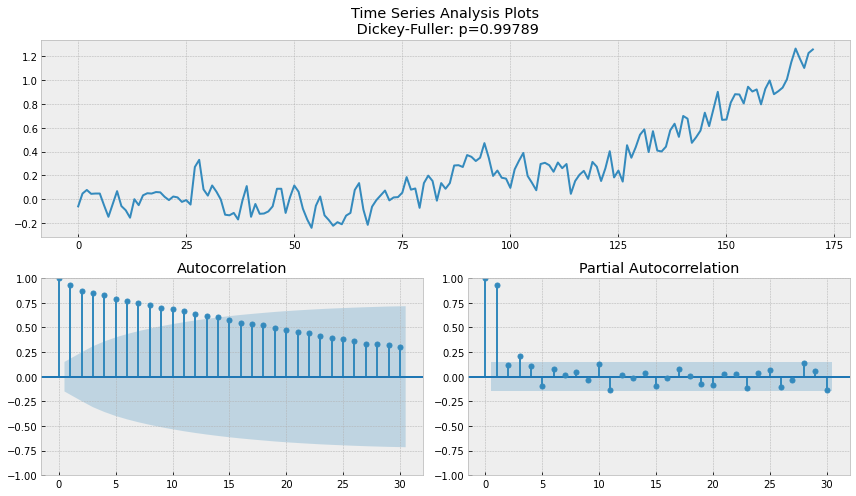

In [5]:
tsplot(df_global_temp.temperature, lags=30)

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



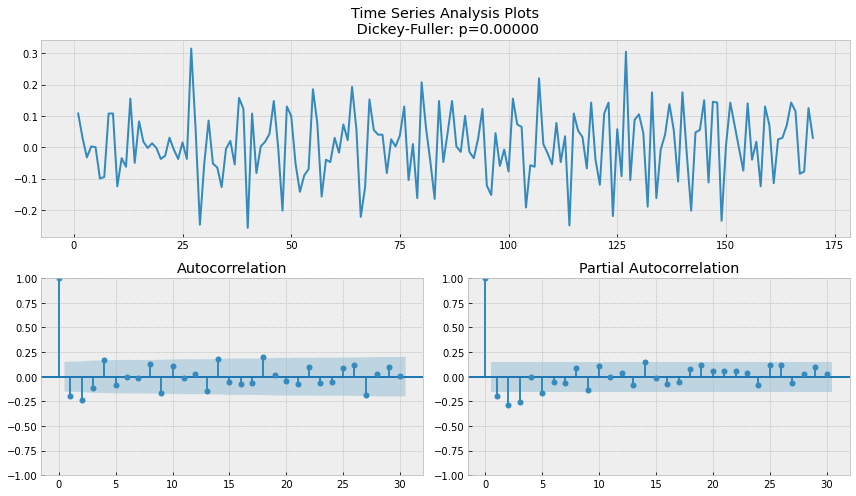

In [6]:
# Take the first difference to remove to make the process stationary
data_diff = df_global_temp.temperature - df_global_temp.temperature.shift(1)

tsplot(data_diff[1:], lags=30)   #start from 1 implies day0-day1

#lollipops within airwindow --> correlated

In [7]:
data_diff.head()

0       NaN
1    0.1075
2    0.0300
3   -0.0325
4    0.0025
Name: temperature, dtype: float64

In [8]:
data_diffl = data_diff.to_list()

In [9]:
df_global_temp["TempDiff"] = data_diffl

In [10]:
df_global_temp = df_global_temp.dropna()
df_global_temp.drop("temperature",inplace=True,axis=1)
df_global_temp.head()

,year,TempDiff
1,1851,0.1075
2,1852,0.0300
3,1853,-0.0325
4,1854,0.0025
5,1855,0.0000


In [11]:
df_global_temp = df_global_temp.set_index("year")

In [12]:
df_global_temp.head()

,TempDiff
year,
1851,0.1075
1852,0.0300
1853,-0.0325
1854,0.0025
1855,0.0000


In [13]:
stepwise_model = auto_arima(df_global_temp, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.51 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-11.930, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-67.372, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-34.688, Time=0.22 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-85.109, Time=0.83 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.85 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-49.069, Time=0.36 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-118.294, Time=0.85 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-110.148, Time=0.39 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.92 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.78 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-154.198, Time=1.67 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=-139.847, T

In [14]:
n_test = 24
train_data = df_global_temp.iloc[:len(df_global_temp) - n_test]
test_data = df_global_temp.iloc[len(df_global_temp) - n_test:]

In [15]:
model = SARIMAX(train_data['TempDiff'],order=(3,1,0),seasonal_order=(2,1,0,12))
results = model.fit()

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [16]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = results.predict(start=start,end=end,dynamic=False,typ='levels').rename('SARIMA Predictions')

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [17]:
len(predictions)

24

In [18]:
predictions

146    0.071253
147    0.016666
148    0.131885
149   -0.116387
150    0.130305
151    0.102861
152    0.064650
153   -0.045006
154    0.116809
155   -0.013063
156    0.092861
157   -0.027781
158    0.107094
159   -0.021459
160    0.137162
161   -0.022755
162    0.148099
163    0.087516
164    0.075031
165   -0.012041
166    0.103096
167   -0.019967
168    0.171364
169   -0.069514
Name: SARIMA Predictions, dtype: float64

In [19]:
future_forecast_sar = predictions.to_list()

In [20]:
future_forecast_df_sar = pd.DataFrame(future_forecast_sar,index = test_data.index,columns=["temperature_forecast"])
pd.concat([test_data,future_forecast_df_sar],axis=1).iplot(categoryorder = "category ascending")

## Sea Level Rise ARIMA prediction and modelling

In [21]:
df_sea_level = pd.read_csv(r"Dataset/csiro_alt_gmsl_mo_2015_csv.csv", error_bad_lines=False, lineterminator='\n')
df_sea_level.head()

,Time,GMSL
0,1993-01-15,-1.6
1,1993-02-15,-3.4
2,1993-03-15,5.5
3,1993-04-15,0.1
4,1993-05-15,5.3


In [22]:
df_sea_level.rename(columns = {'GMSL\r':'GMSL'}, inplace = True)
df_sea_level = df_sea_level.dropna()

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



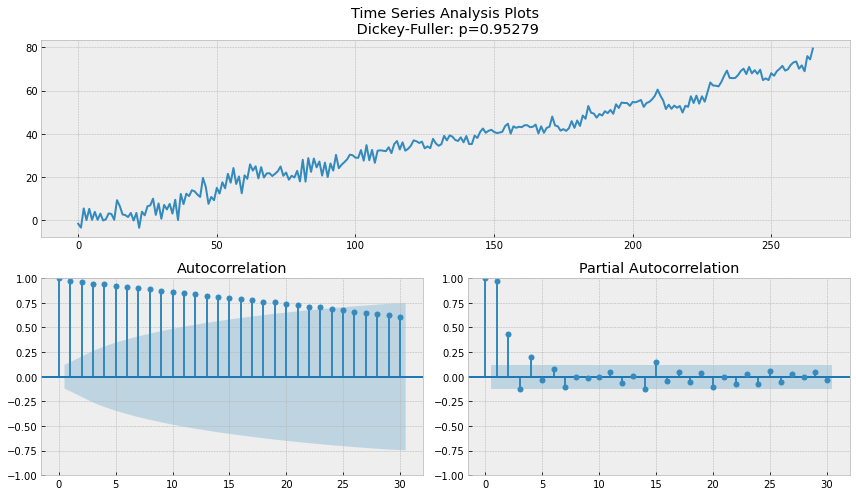

In [23]:
tsplot(df_sea_level.GMSL, lags=30)

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



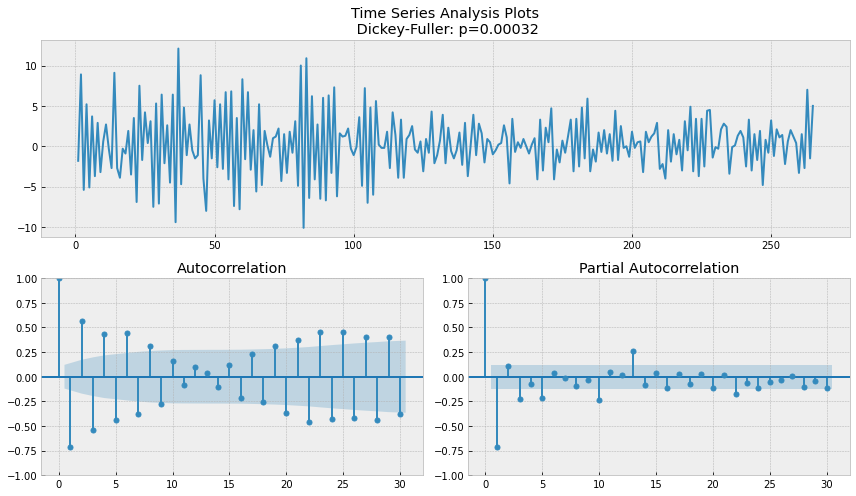

In [24]:
# Take the first difference to remove to make the process stationary
data_diff = df_sea_level.GMSL - df_sea_level.GMSL.shift(1)

tsplot(data_diff[1:], lags=30)   #start from 1 implies day0-day1

#lollipops within airwindow --> correlated

In [25]:
data_diffl = data_diff.to_list()
df_sea_level["GMSL_Diff"] = data_diffl
df_sea_level.drop("GMSL",inplace=True,axis=1)
df_sea_level = df_sea_level.dropna()
df_sea_level = df_sea_level.set_index("Time")
df_sea_level.head()

,GMSL_Diff
Time,
1993-02-15,-1.8
1993-03-15,8.9
1993-04-15,-5.4
1993-05-15,5.2
1993-06-15,-5.1


In [26]:
stepwise_model = auto_arima(df_sea_level, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.24 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1842.784, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1415.191, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1459.361, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1380.006, Time=0.53 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=1351.169, Time=1.65 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=1353.166, Time=2.53 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=1.73 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.38 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=1326.452, Time=1.91 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=1327.528, Time=0.69 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1351.103, Time=0.78 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=1

In [27]:
n_test = 24
train_data = df_sea_level.iloc[:len(df_sea_level) - n_test]
test_data = df_sea_level.iloc[len(df_sea_level) - n_test:]

In [28]:
model_sea_level = SARIMAX(train_data['GMSL_Diff'],order=(3,1,0),seasonal_order=(2,1,1,12))
results_sea_level = model_sea_level.fit()

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [29]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = results_sea_level.predict(start=start,end=end,dynamic=False,typ='levels').rename('SARIMA Predictions')

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [30]:
future_forecast_sar = predictions.to_list()

In [31]:
future_forecast_df_sar = pd.DataFrame(future_forecast_sar,index = test_data.index,columns=["sealevel_prediction"])
pd.concat([test_data,future_forecast_df_sar],axis=1).iplot(categoryorder = "category ascending")

### References

https://ourworldindata.org/grapher/forest-transition-phase?country=~BOL
<br>
https://ourworldindata.org/grapher/commodity-deforestation-by-region
<br>
https://www.kaggle.com/gianlab/consumption-in-the-world-of-fossil-fuel/data
<br>
https://ourworldindata.org/grapher/annual-deforestation
<br>
https://www.kaggle.com/rishidamarla/global-rise-in-temperatures-in-each-country
<br>
https://ourworldindata.org/grapher/net-deforestation-in-trade?tab=chart
<br>
https://datahub.io/core/sea-level-rise#data
<br>
https://www.kaggle.com/txtrouble/carbon-emissions
<br>
https://machinelearningmastery.com/how-to-develop-deep-learning-models-for-univariate-time-series-forecasting/
<br>
https://towardsdatascience.com/lstm-framework-for-univariate-time-series-prediction-d9e7252699e
<br>